# UV TRNU.CSN - Data and Machine Learning
## Unsupervised learning - TP Clustering - 2025

Christelle Garnier

### Aim of the TP

The aim of this practical work is:
- to perform clustering on data in order to automatically create categories by leveraging the classes and functions provided by the `Scikit-Learn` and `SciPy` libraries. 
- The methods to be implemented and tested are hierarchical agglomerative clustering and K-means algorithms. 


### Dataset 'hotels.csv'

The work consists of performing a clustering on the data contained in the file 'hotels.csv' available on MyLearningSpace. 

Start by looking at the file. It contains information about a set of hotels: NOM (name), PAYS (country), ETOILE (number of stars), CONFORT (comfort rating), CHAMBRE (number of rooms), CUISINE (food rating), SPORT (sport rating), PLAGE (beach rating), PRIX (price per night in euros).

The objective is to automatically group hotels of similar standing. The clustering can  identify several categories of hotels, which will be compared with the star-based classification.

### Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans

### 1. Reading the Data

1. Load the file 'hotels.csv' using `read_csv()` from the `pandas` library. Check the import by using the methods and attributes available for the `DataFrame` class, such as `info()`, `describe()`, `shape`, and `head()`.

1. Decide which variables to keep for clustering and store the corresponding columns separately so that the values of these variables can be retrieved later. In particular, you will need to name the hotels in graphical representations of the clusters.

1. Remove the unused columns with the `drop()` method of the `DataFrame` class.

1. Store the names of the remaining columns using the `columns` attribute of the `DataFrame` class so that the names of the variables/features used for clustering can be retrieved later. 

In [11]:
# 1. Load the dataset
data = pd.read_csv('hotels.csv')
data.head()

,NOM,PAYS,ETOILE,CONFORT,CHAMBRE,CUISINE,SPORT,PLAGE,PRIX
0,Appolpon,Grece,1,4,56,2,0,8,390
1,Caravel,Grece,4,7,471,7,6,5,468
2,Christina,Grece,2,7,93,3,0,5,427
3,Economy,Grece,1,3,56,1,0,8,369
4,EdenBeach,Grece,1,4,286,3,4,7,499


In [12]:
# 2. Decide to remove the non-numeric columns

# 3. Remove the non-numeric columns
data = data.drop(columns=['NOM', 'PAYS', 'ETOILE'])
# print(data)

# 4. Store the column names
data_columns = data.columns
print(data_columns)

Index(['CONFORT', 'CHAMBRE', 'CUISINE', 'SPORT', 'PLAGE', 'PRIX'], dtype='object')


### 2. Exploring the Data

Once the data has been imported and selected, begin with a preliminary analysis to identify relationships between the variables.

1. Compute the correlation coefficients between all pairs of numerical variables using the `corr()` method of the `DataFrame` class and visualize the correlation matrix as a heatmap using the `heatmap()` function from the `seaborn` library. 

1. Identify which variables are the most strongly correlated (positively and negatively), and which ones show the weakest correlations.

Text(0.5, 1.0, 'Hotels Correlation Matrix Heatmap')

Text(0.5, 1.0, 'Hotels Correlation Matrix Heatmap')

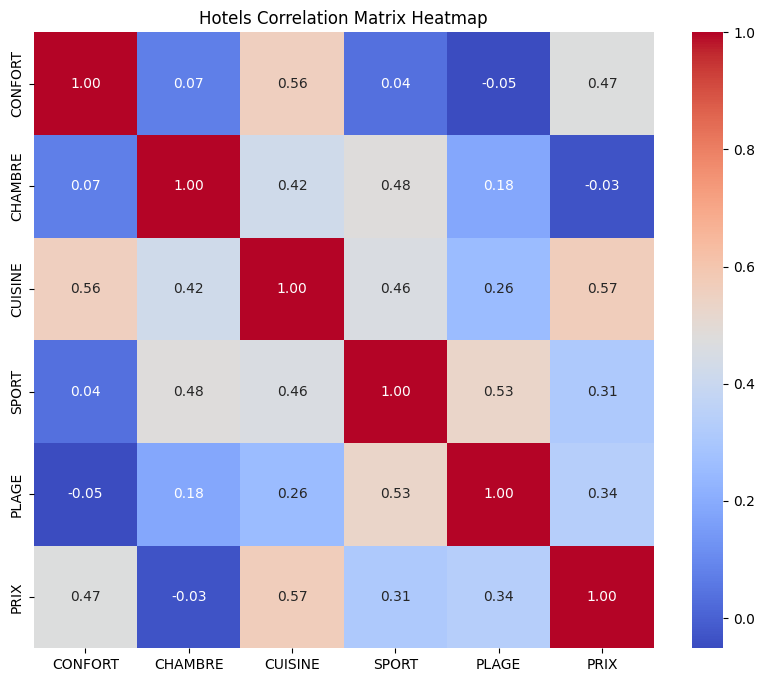

In [13]:
# 1. Use the correlation matrice and visualize with a heatmap
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Hotels Correlation Matrix Heatmap')

### 3. Preprocessing the Data
To perform clustering, the data must be centered and scaled:

1. First, convert the `DataFrame` object into a `numpy` array by using the `to_numpy()` method of the `DataFrame` class.

1. Next, use the `StandardScaler` class from `sklearn.preprocessing` to center and scale the data. Use the `fit()` and `transform()` methods to obtain the normalized data matrix.




In [14]:
# 1
df_np = data.to_numpy()

# 2
df_np = StandardScaler().fit_transform(df_np)

### 4. Visualizing the Data

Before clustering, it is useful to represent the data in 2 dimensions to check whether they have a specific natural structure and if any clusters visually appear.

1. Perform a PCA with 2 components using the `PCA` class from `sklearn.decomposition`. Compute the overall quality of the representation. 

2. Use the `transform()` method of the `PCA` class to obtain the principal components (coordinates of the observations on axes 0 and 1).

3.  Represent the observations on the first principal plane using the `scatter()` function from `matplotlib.pyplot`. For each point, it is useful to write the hotel name and the star rating with the `text()` function from `matplotlib.pyplot`. 

4. Do any obvious clusters appear visually?

Explained variance by PC1: 0.436
Explained variance by PC2: 0.236
Total variance explained with 2 components: 0.671


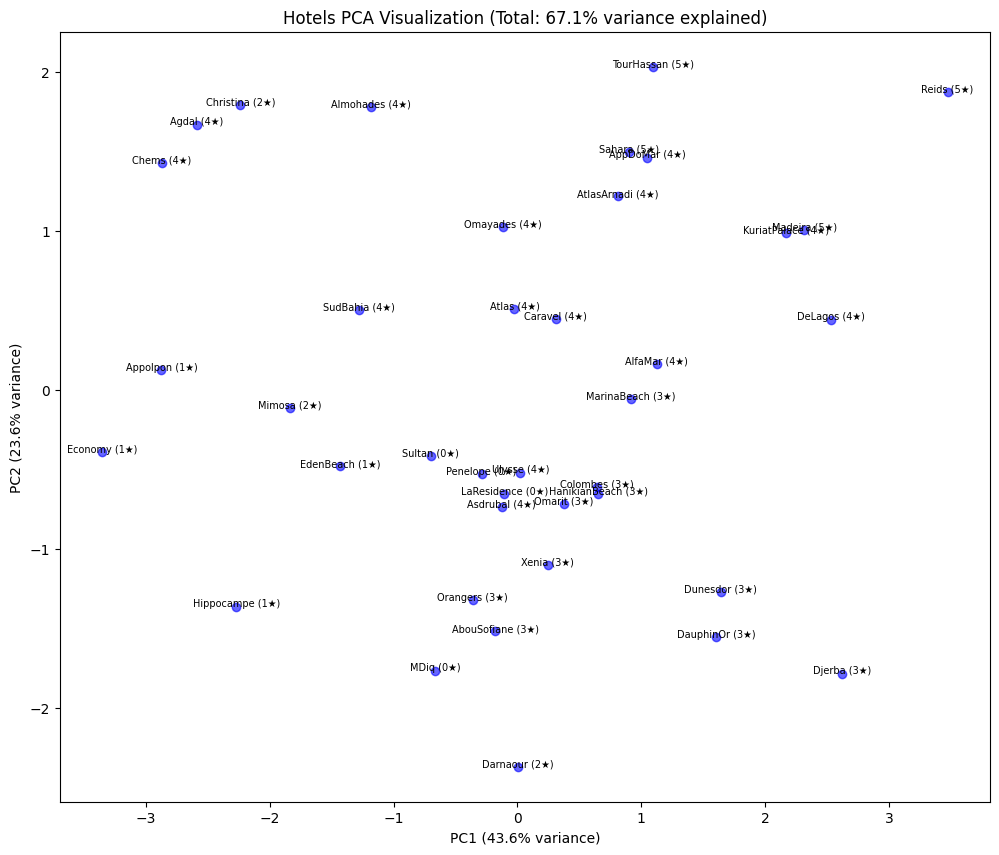

In [15]:
# 1
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(df_np)

# 2
explained_variance = pca.explained_variance_ratio_
total_variance_explained = np.sum(explained_variance)
print(f"Explained variance by PC1: {explained_variance[0]:.3f}")
print(f"Explained variance by PC2: {explained_variance[1]:.3f}")
print(f"Total variance explained with 2 components: {total_variance_explained:.3f}")

# 3
original_data = pd.read_csv('hotels.csv')
hotel_names = original_data['NOM']
hotel_stars = original_data['ETOILE']

plt.figure(figsize=(12, 10))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c='blue', alpha=0.6)

# Label with name and star
for i in range(len(pca_coords)):
    plt.text(
        pca_coords[i, 0], pca_coords[i, 1], 
        f'{hotel_names[i]} ({hotel_stars[i]}★)', 
        fontsize=7,
        ha='center'
    )

plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
plt.title(f'Hotels PCA Visualization (Total: {total_variance_explained:.1%} variance explained)')
plt.show()

# 4. The PCA visualization helps to identify patterns and clusters among hotels based on their features.


### 5. Agglomerative Hierarchical Clustering

1. To implement agglomerative hierarchical clustering in Python, we use the `scipy.cluster.hierarchy` module, mainly the functions `dendrogram`, `linkage`, and `fcluster`. Study these functions.

1. We will consider the Euclidean metric for calculating distances between points and different linkage methods for calculating distances between clusters: single, complete, average, centroid, and ward. 
    For each of these linkage methods:

    1. Perform the full agglomerative hierarchical clustering using the `linkage` function (with parameter `optimal_ordering=True` for better visualization of the results). This function returns a linkage matrix.

    1. Represent this linkage matrix as a dendrogram using the `dendrogram` function (with parameter `color_threshold=0` to obtain the full dendrogram).

1. Visually identify the linkage method that produces the best partitions (homogeneous and well-separated clusters).
    

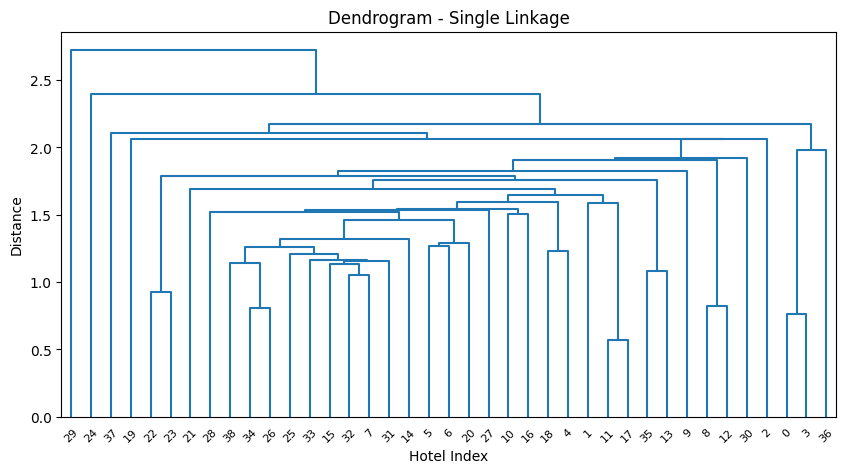

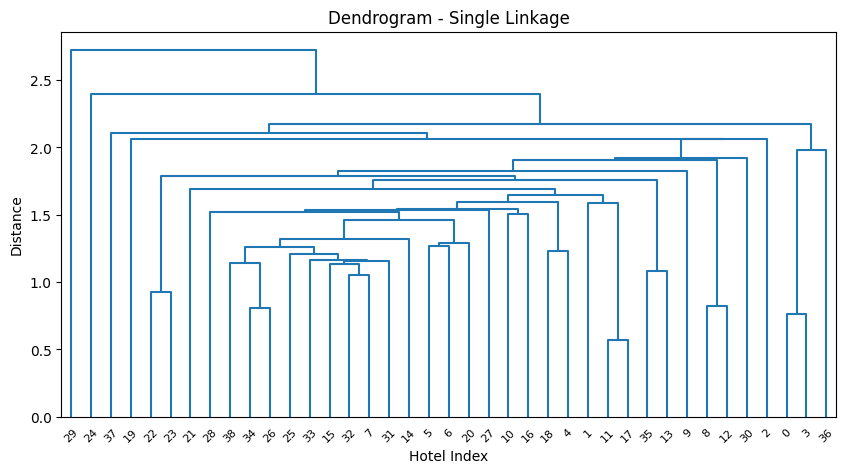

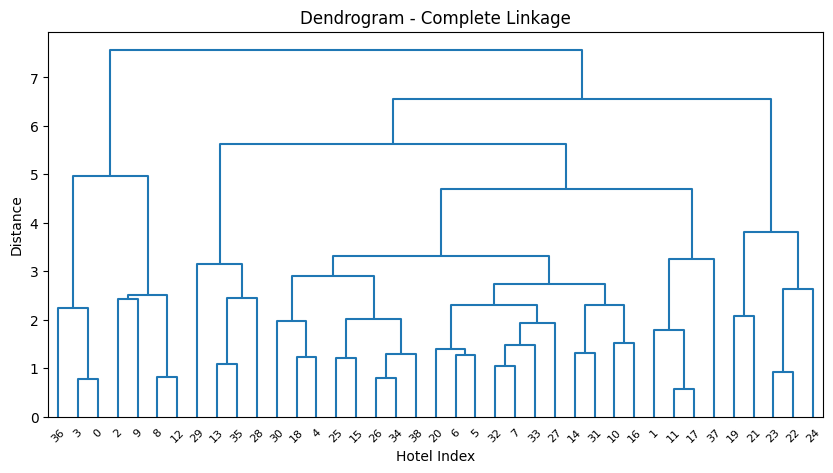

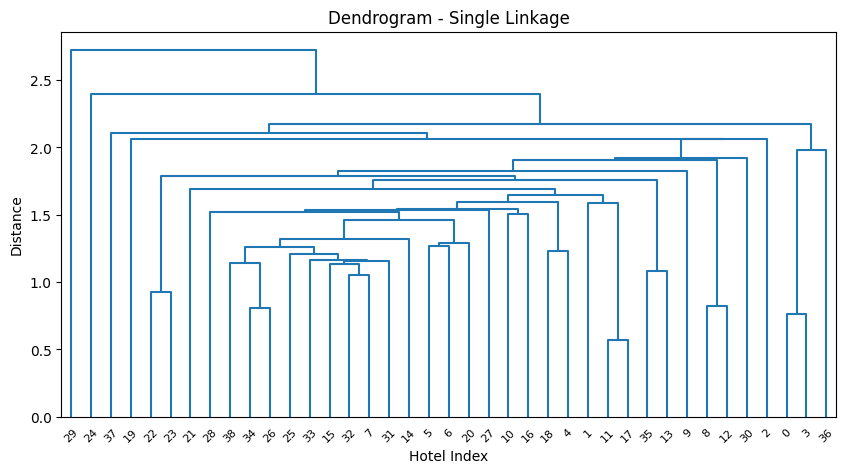

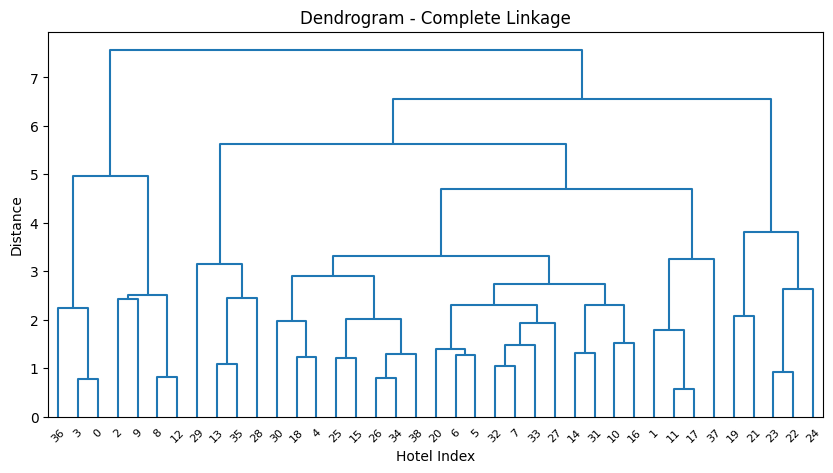

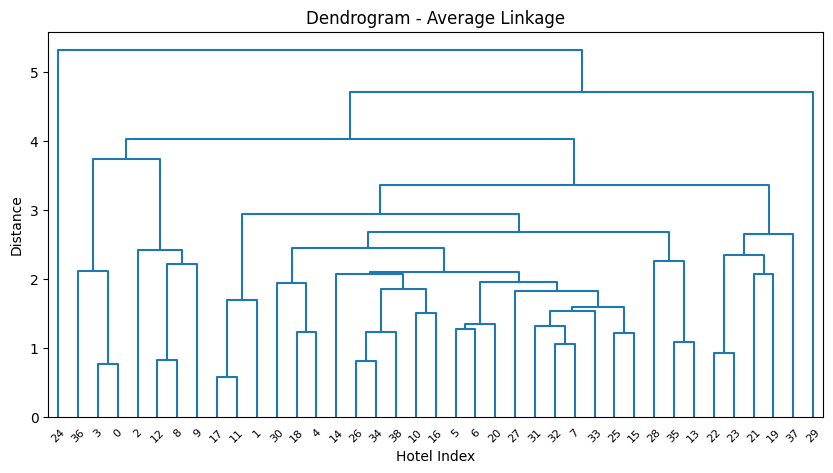

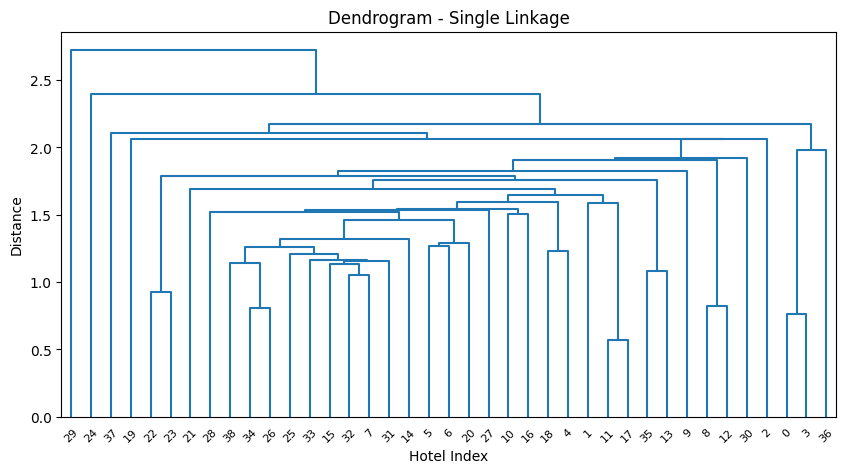

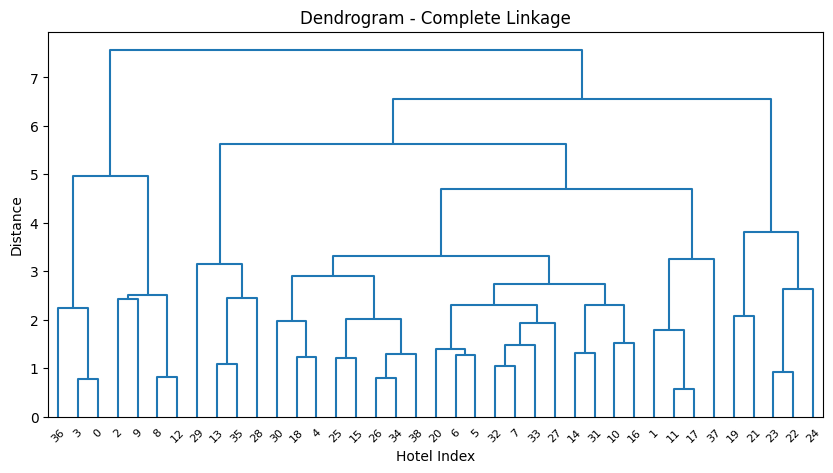

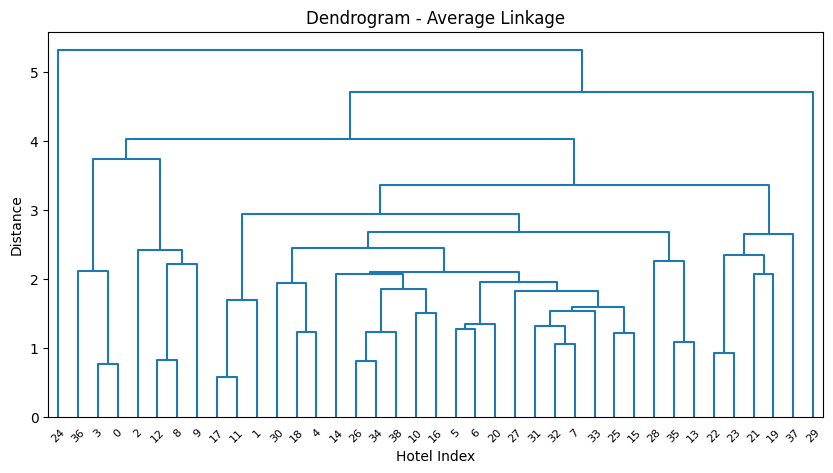

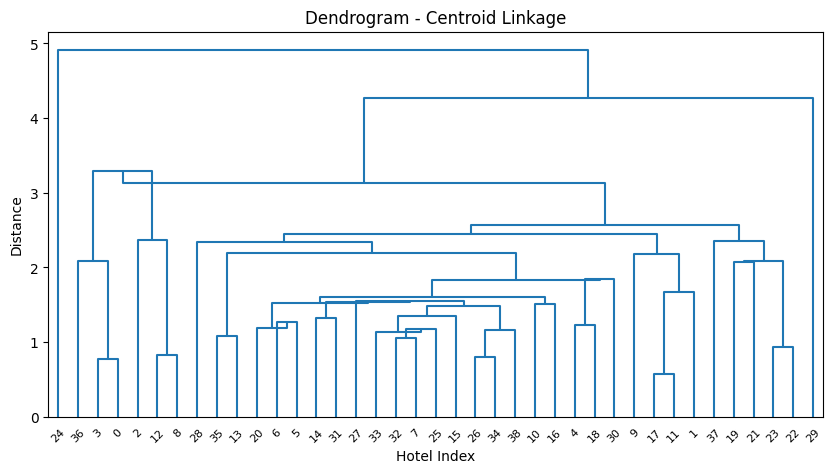

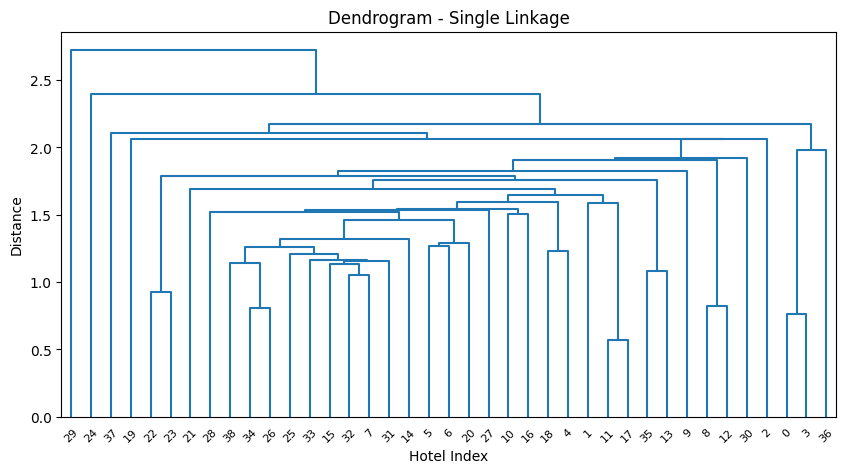

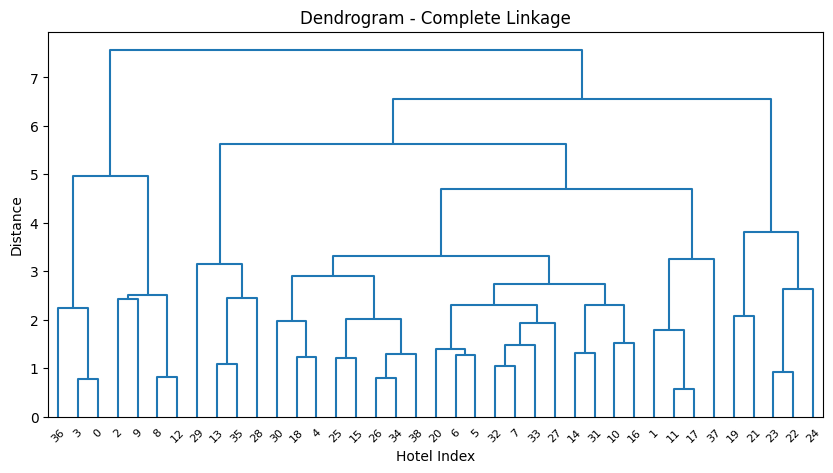

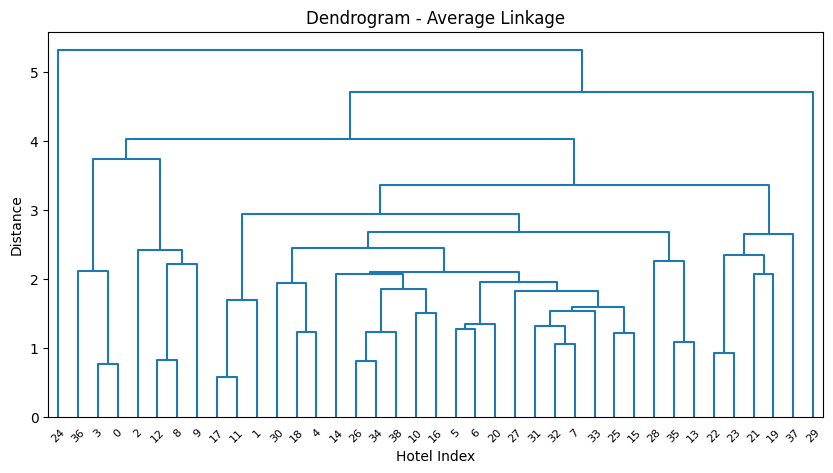

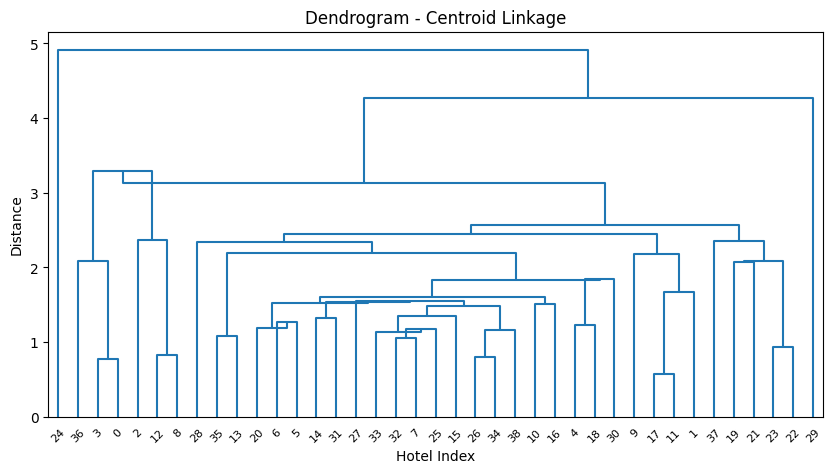

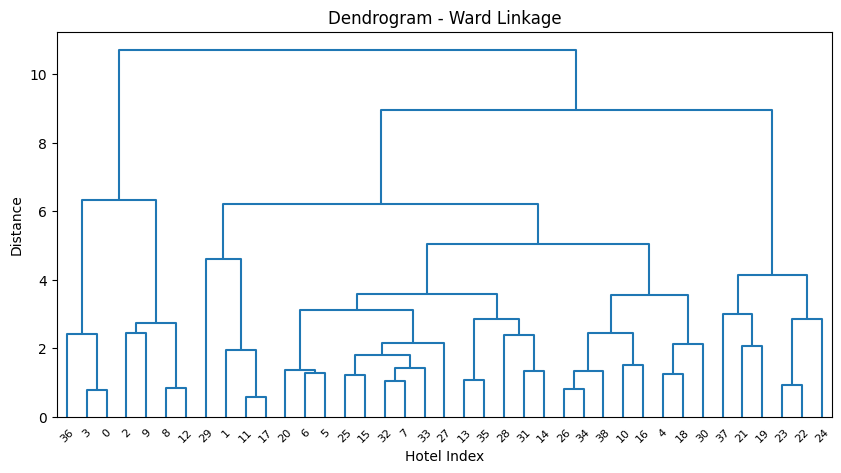

1. Single: Create elongated clusters
2. Complete: Create more compact and well distributed clusters
3. Average: Balance between single and complete
4. Centroid: Can produce inversions in the dendrogram
5. Ward: Minimize intra-cluster variance, usually gives good results

Answer: In my concept the complet and ward methods produce clearer and more balanced cuts.


In [18]:
# 2. Create the linkage by each method
linkage_matrix_single = linkage(df_np, method='single', optimal_ordering=True)
linkage_matrix_complete = linkage(df_np, method='complete', optimal_ordering=True)
linkage_matrix_average = linkage(df_np, method='average', optimal_ordering=True)
linkage_matrix_centroid = linkage(df_np, method='centroid', optimal_ordering=True)
linkage_matrix_ward = linkage(df_np, method='ward', optimal_ordering=True)

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_single, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Single Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_complete, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Complete Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_average, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Average Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_centroid, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Centroid Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_ward, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Ward Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

# 3. Compare the dendrograms by visual analysis
print('1. Single: Create elongated clusters')
print('2. Complete: Create more compact and well distributed clusters')
print('3. Average: Balance between single and complete')
print('4. Centroid: Can produce inversions in the dendrogram')
print('5. Ward: Minimize intra-cluster variance, usually gives good results')
print('\nAnswer: In my concept the complet and ward methods produce clearer and more balanced cuts.')

### 6. Agglomerative Hierarchical Clustering (continued)

1. For the selected linkage method, propose a few (2 or 3) relevant values for the number $K$ of clusters.
    For each value of $K$:
    
    1. Determine on the dendrogram the required threshold (or height) $t$ to cut the tree. Display the clusters in color on the dendrogram by running the `dendrogram` function again with `color_threshold=t`.

    1. Perform clustering using the `fcluster` function with this threshold $t$ and the distance criterion (`criterion='distance'`). Print the result of the function, which is a vector containing, for each data point, the label (number) of its cluster.

    1. To evaluate the quality of the clustering, calculate the silhouette score using the `silhouette.score` function from the `sklearn.metrics` module. 

1. Compare the results and determine the best partition (according to silhouette score).

1. For this best partition, list the names and star ratings of the hotels in each cluster. To retrieve the indices of the hotels assigned to clusters, the simplest method is to use the `argsort` function from `numpy`: the returned indices correspond to the cluster labels sorted in ascending order.

1. For cluster visualization, color the points belonging to the same cluster with a specific color on the previous 2D representation obtained by PCA. Analyze the clustering result. 


In [17]:
# 6.1.1
t0 = 4 # Threshold distance to cut the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix_complete, color_threshold=t, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Ward Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.axhline(y=t0-0.25, color='red', linestyle='--')
plt.show()

NameError: name 't' is not defined

<Figure size 1000x700 with 0 Axes>

In [ ]:
# 6.1.2
labels = fcluster(linkage_matrix_complete, t=t0, criterion='distance')
print("Cluster labels:", labels)  

# 6.1.3
silhouette_score(df_np, labels)

Cluster labels: [1 5 2 1 4 4 4 4 2 2 4 5 2 3 4 4 4 5 4 6 4 6 6 6 6 4 4 4 3 3 4 4 4 4 4 3 1
 5 4]


0.2534435310699295

Using ward linkage method for clustering analysis
Testing different numbers of clusters (K=2, 3, 4)...

--- Testing K=2 ---


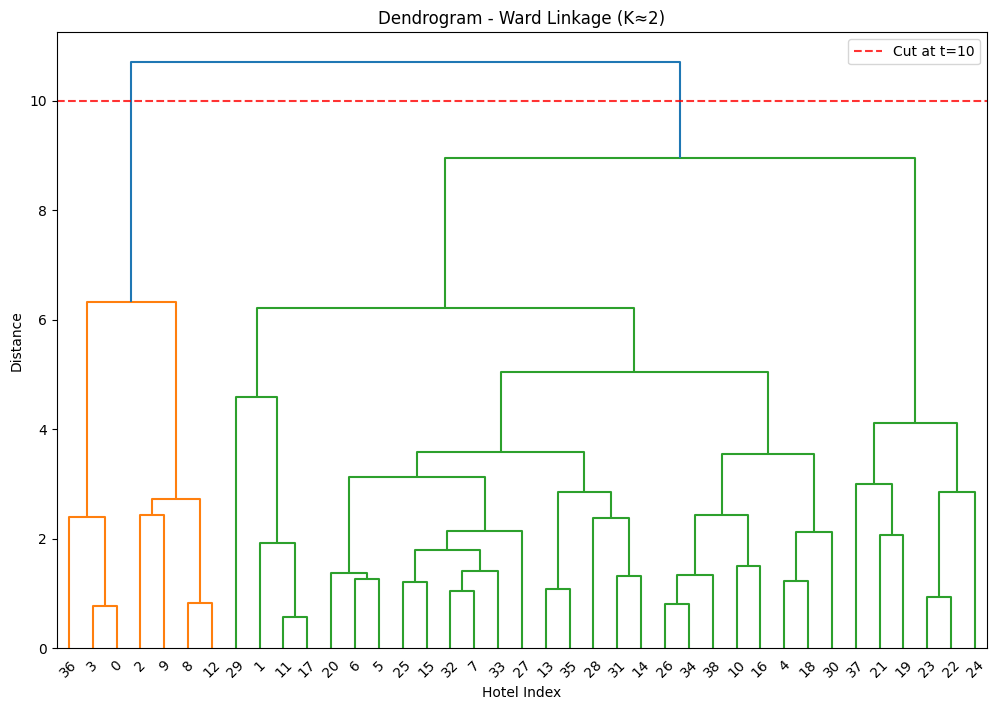

Using ward linkage method for clustering analysis
Testing different numbers of clusters (K=2, 3, 4)...

--- Testing K=2 ---


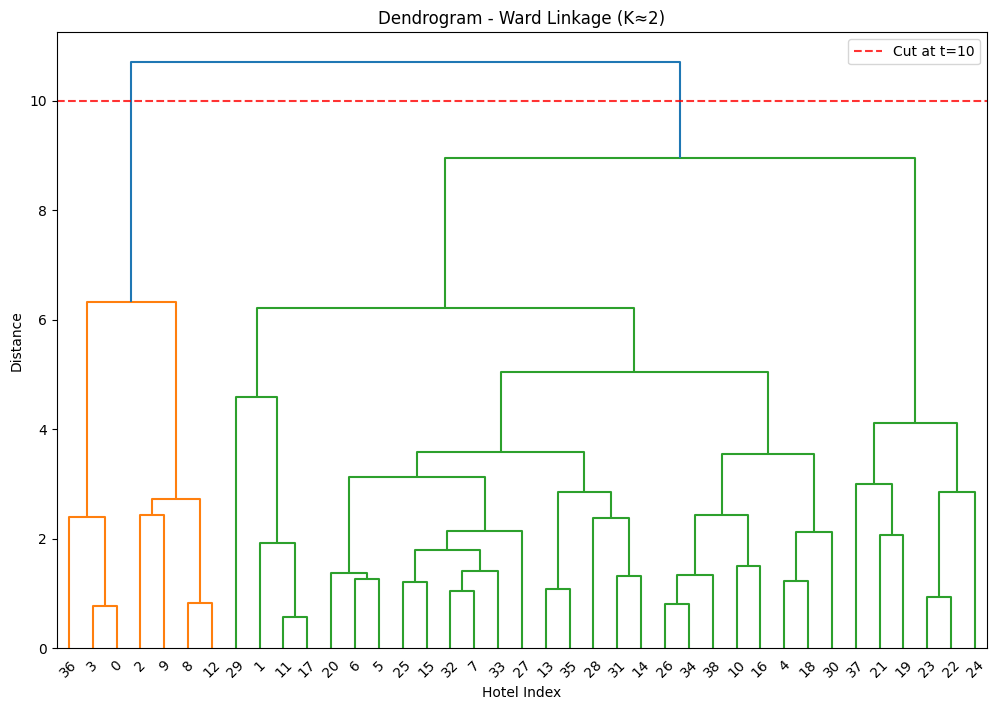

K=2: Silhouette score = 0.290

--- Testing K=3 ---


Using ward linkage method for clustering analysis
Testing different numbers of clusters (K=2, 3, 4)...

--- Testing K=2 ---


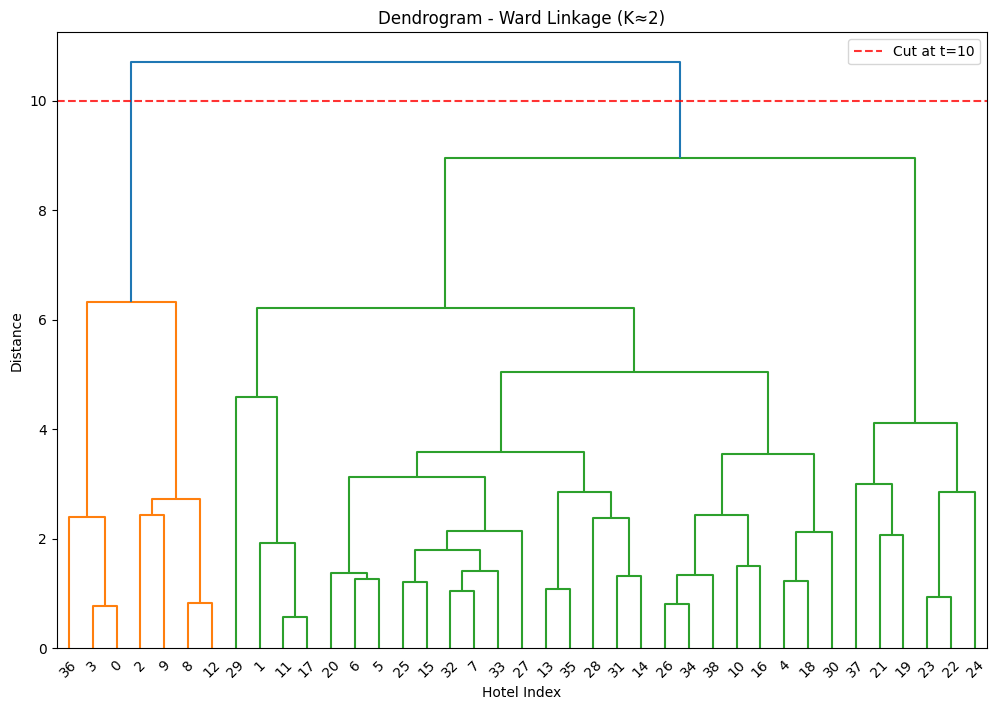

K=2: Silhouette score = 0.290

--- Testing K=3 ---


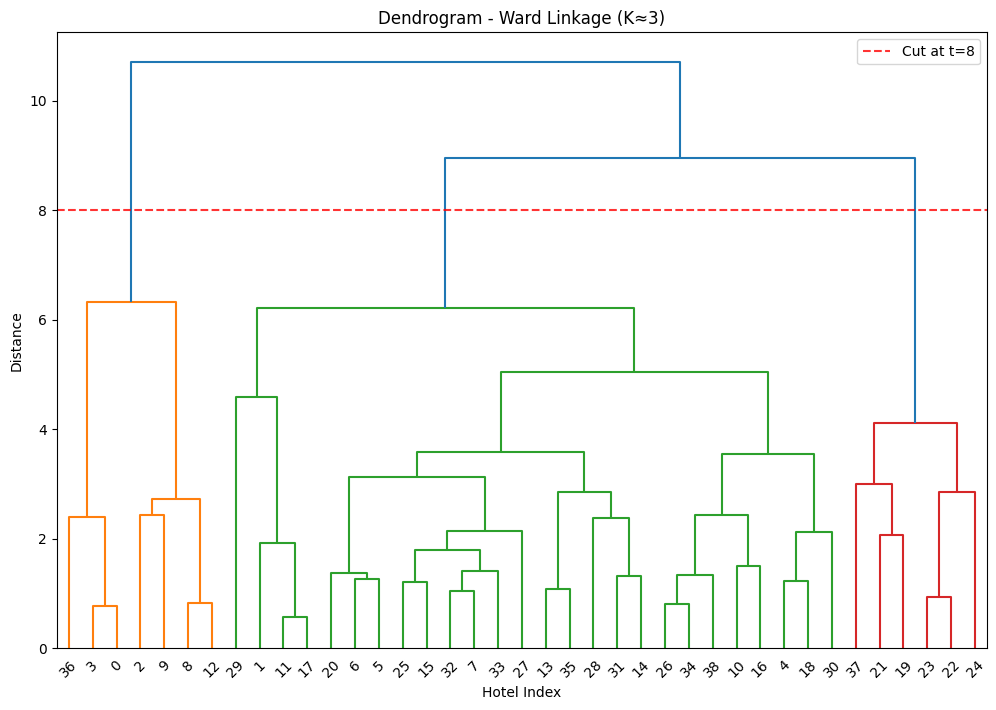

Using ward linkage method for clustering analysis
Testing different numbers of clusters (K=2, 3, 4)...

--- Testing K=2 ---


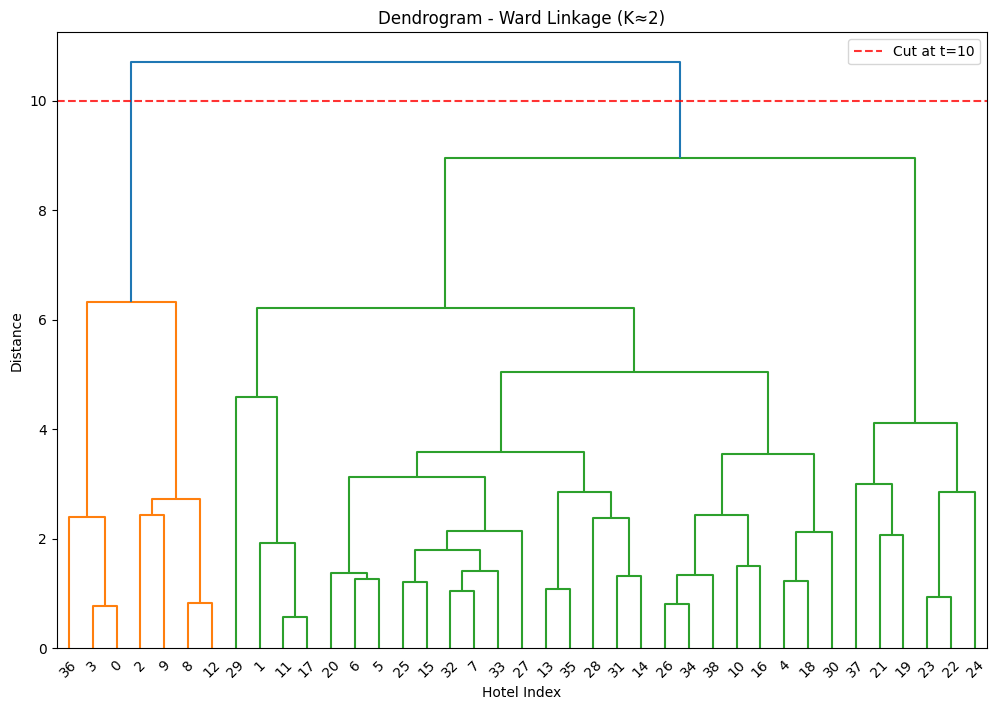

K=2: Silhouette score = 0.290

--- Testing K=3 ---


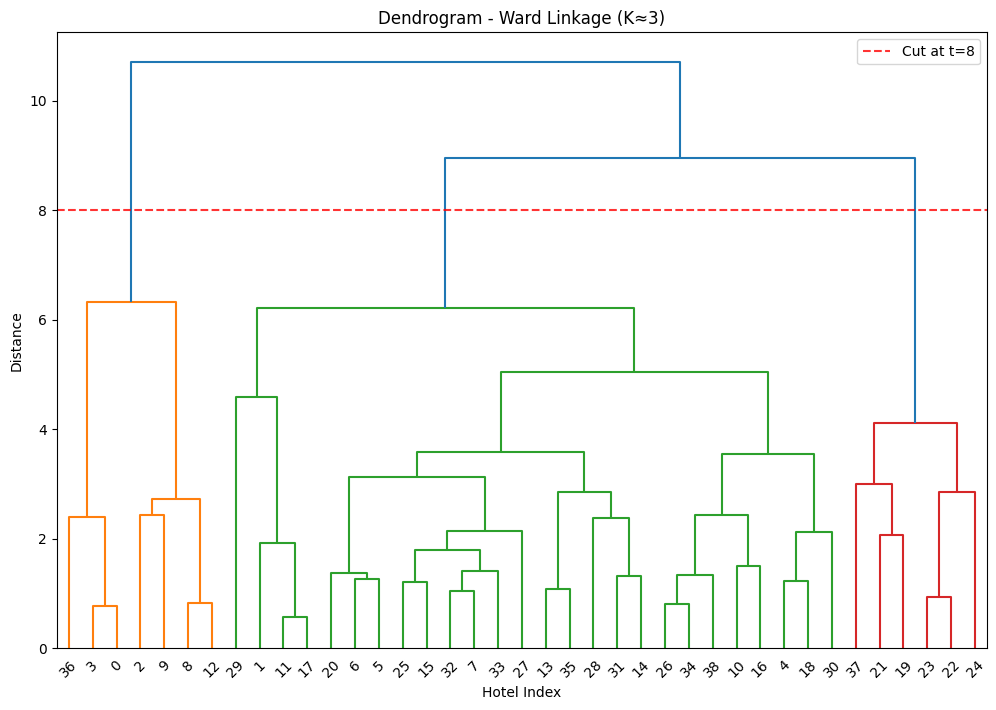

K=3: Silhouette score = 0.250

--- Testing K=4 ---


Using ward linkage method for clustering analysis
Testing different numbers of clusters (K=2, 3, 4)...

--- Testing K=2 ---


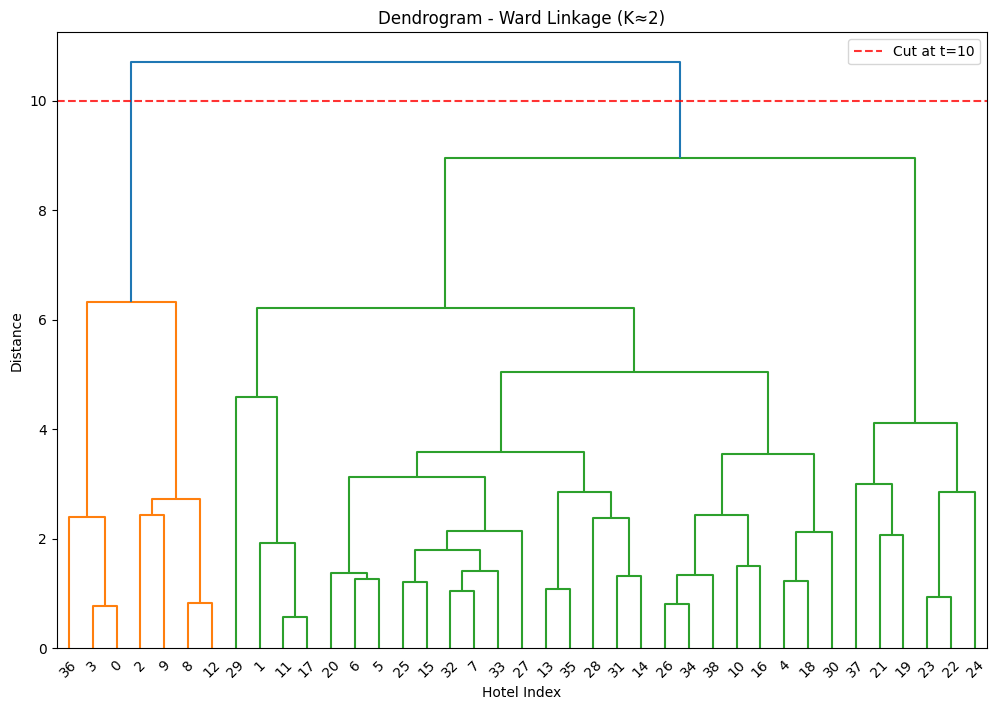

K=2: Silhouette score = 0.290

--- Testing K=3 ---


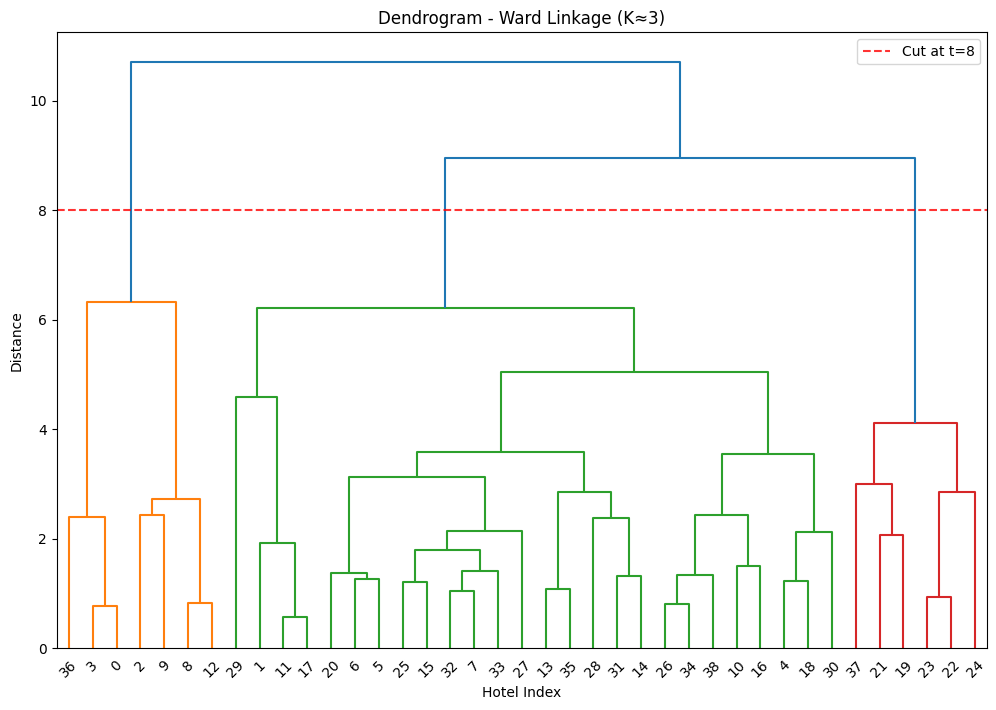

K=3: Silhouette score = 0.250

--- Testing K=4 ---


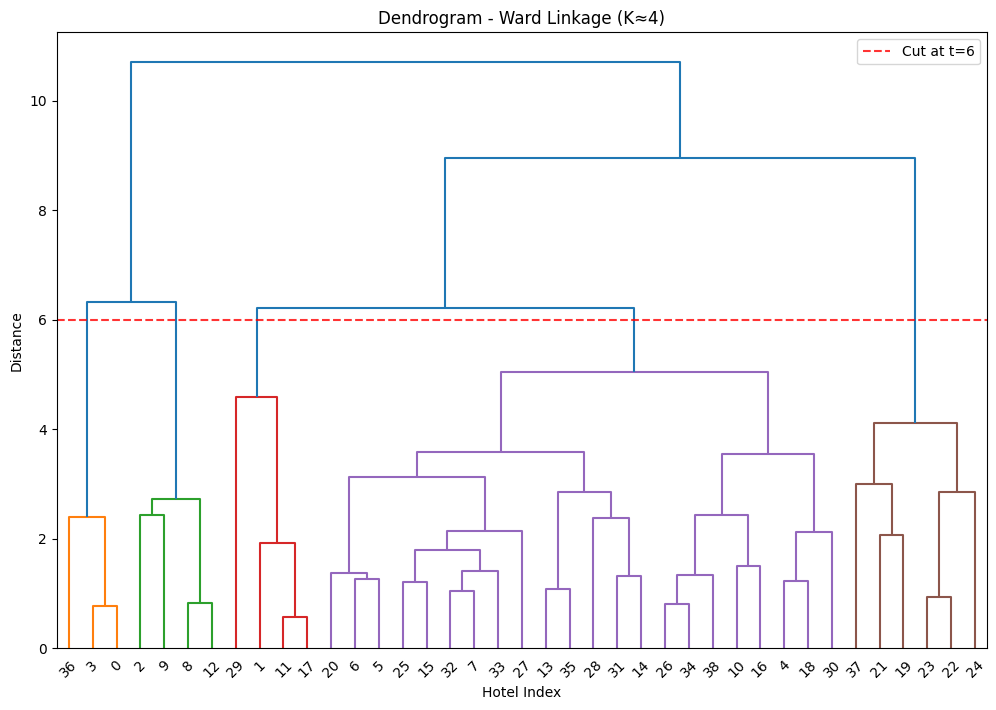

K=4: Silhouette score = 0.268

=== COMPARISON OF RESULTS ===
K=2: Silhouette = 0.290
K=3: Silhouette = 0.250
K=4: Silhouette = 0.268

Best result: K=2 with silhouette score = 0.290


In [19]:
# Selected method: Ward
selected_method = 'ward'
linkage_matrix_selected = linkage_matrix_ward

print(f"Using {selected_method} linkage method for clustering analysis")
print("Testing different numbers of clusters (K=2, 3, 4)...")

# === K=2 CLUSTERS ===
print("\n--- Testing K=2 ---")
t2 = 10  # Threshold for approximately 2 clusters
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix_ward, color_threshold=t2, leaf_font_size=10)
plt.title('Dendrogram - Ward Linkage (K≈2)')  
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.axhline(y=t2, color='red', linestyle='--', alpha=0.8, label=f'Cut at t={t2}')
plt.legend()
plt.show()

labels_2 = fcluster(linkage_matrix_ward, t2, criterion='distance')
score_2 = silhouette_score(df_np, labels_2)
print(f"K=2: Silhouette score = {score_2:.3f}")

# === K=3 CLUSTERS ===  
print("\n--- Testing K=3 ---")
t3 = 8  # Threshold for approximately 3 clusters
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix_ward, color_threshold=t3, leaf_font_size=10)
plt.title('Dendrogram - Ward Linkage (K≈3)')
plt.xlabel('Hotel Index') 
plt.ylabel('Distance')
plt.axhline(y=t3, color='red', linestyle='--', alpha=0.8, label=f'Cut at t={t3}')
plt.legend()
plt.show()

labels_3 = fcluster(linkage_matrix_ward, t3, criterion='distance')
score_3 = silhouette_score(df_np, labels_3)
print(f"K=3: Silhouette score = {score_3:.3f}")

# === K=4 CLUSTERS ===
print("\n--- Testing K=4 ---")
t4 = 6  # Threshold for approximately 4 clusters
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix_ward, color_threshold=t4, leaf_font_size=10)
plt.title('Dendrogram - Ward Linkage (K≈4)')
plt.xlabel('Hotel Index')
plt.ylabel('Distance') 
plt.axhline(y=t4, color='red', linestyle='--', alpha=0.8, label=f'Cut at t={t4}')
plt.legend()
plt.show()

labels_4 = fcluster(linkage_matrix_ward, t4, criterion='distance')
score_4 = silhouette_score(df_np, labels_4)
print(f"K=4: Silhouette score = {score_4:.3f}")

# Compare results
print(f"\n=== COMPARISON OF RESULTS ===")
print(f"K=2: Silhouette = {score_2:.3f}")
print(f"K=3: Silhouette = {score_3:.3f}")  
print(f"K=4: Silhouette = {score_4:.3f}")

# Select best result based on highest silhouette score
if score_2 >= score_3 and score_2 >= score_4:
    print(f"\nBest result: K=2 with silhouette score = {score_2:.3f}")
    best_labels = labels_2
    best_k = 2
    best_t = t2
elif score_3 >= score_4:
    print(f"\nBest result: K=3 with silhouette score = {score_3:.3f}")
    best_labels = labels_3
    best_k = 3
    best_t = t3
else:
    print(f"\nBest result: K=4 with silhouette score = {score_4:.3f}")
    best_labels = labels_4
    best_k = 4
    best_t = t4

### 7. K-Means

1. To implement the K-means algorithm in Python, we use the `KMeans` class from the `sklearn.cluster` module. Study this class:
  - call parameters: `n_clusters`, `init`, and `n_init`,
  - attributes: `labels_`, `inertia_`, and `cluster_centers_`,
  - methods: `fit()`.

2. Apply the K-means algorithm for a number of clusters $K$ of your choice, first with a random initialization (`init='random'`) and a single run (`n_init=1`). Compute the inertia of the obtained partition using the `inertia_` attribute and the silhouette score using the `silhouette.score` function from the `sklearn.metrics` module. 

3. Run the algorithm a second time, compute again the inertia and the silhouette score, and compare the new partition with the previous one by calculating the Adjusted Rand Index (ARI) using the `adjusted_rand_score` function from the `sklearn.metrics` module.

4. Do the same with the `k-means++` initialization method and multiple runs (`n_init=10`). Comment on the stability of the K-means algorithm. 

5. Determine the optimal value of $K$ using the two methods seen in class: the elbow method and the silhouette method (you can vary $K$ from 2 to 10).

In [26]:
# 7.2 Apply K-means with random initialization and single run
kmeans_random = KMeans(n_clusters=3, init='random', n_init=1, random_state=42)
kmeans_random.fit(df_np)

print("Results with random initialization:")
print(f"Inertia: {kmeans_random.inertia_:.3f}")
print(f"Silhouette score: {silhouette_score(df_np, kmeans_random.labels_):.3f}")
print(f"Cluster labels: {kmeans_random.labels_}")
print(f"Cluster centers shape: {kmeans_random.cluster_centers_.shape}")
print("Each row is a cluster center with 6 features (CONFORT, CHAMBRE, CUISINE, SPORT, PLAGE, PRIX)")

Results with random initialization:
Inertia: 126.745
Silhouette score: 0.247
Cluster labels: [0 2 0 0 0 2 2 2 0 0 2 1 0 2 2 2 1 1 0 1 1 1 1 1 1 2 2 2 2 2 0 2 2 2 2 2 0
 1 2]
Cluster centers shape: (3, 6)
Each row is a cluster center with 6 features (CONFORT, CHAMBRE, CUISINE, SPORT, PLAGE, PRIX)


In [27]:
# 7.3 Run algorithm a second time to check stability
kmeans_random2 = KMeans(n_clusters=3, init='random', n_init=1, random_state=123)  # Different seed
kmeans_random2.fit(df_np)

print(f"Second run - Inertia: {kmeans_random2.inertia_:.3f}")
print(f"Second run - Silhouette: {silhouette_score(df_np, kmeans_random2.labels_):.3f}")

# Compare the two results using Adjusted Rand Index
ari_random = adjusted_rand_score(kmeans_random.labels_, kmeans_random2.labels_)
print(f"ARI between two random runs: {ari_random:.3f}")

if ari_random < 0.8:
    print("Low ARI suggests random initialization is unstable - results change between runs")

Second run - Inertia: 126.745
Second run - Silhouette: 0.247
ARI between two random runs: 1.000


In [28]:
# 7.4 Now let's try k-means++ initialization with multiple runs
print("\n--- K-means++ initialization (multiple runs) ---")
# k-means++ chooses initial centers smarter, and n_init=10 runs it 10 times
kmeans_plus = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
kmeans_plus.fit(df_np)

print(f"K-means++ - Inertia: {kmeans_plus.inertia_:.3f}")
print(f"K-means++ - Silhouette: {silhouette_score(df_np, kmeans_plus.labels_):.3f}")

# Test stability of k-means++
kmeans_plus2 = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=456)
kmeans_plus2.fit(df_np)

ari_plus = adjusted_rand_score(kmeans_plus.labels_, kmeans_plus2.labels_)
print(f"ARI between two k-means++ runs: {ari_plus:.3f}")

print(f"\nStability comparison:")
print(f"Random init ARI: {ari_random:.3f} ({'Stable' if ari_random > 0.8 else 'Unstable'})")
print(f"K-means++ ARI: {ari_plus:.3f} ({'Stable' if ari_plus > 0.8 else 'Unstable'})")
print("K-means++ is more stable because it chooses better initial centers.")


--- K-means++ initialization (multiple runs) ---
K-means++ - Inertia: 126.745
K-means++ - Silhouette: 0.247
ARI between two k-means++ runs: 1.000

Stability comparison:
Random init ARI: 1.000 (Stable)
K-means++ ARI: 1.000 (Stable)
K-means++ is more stable because it chooses better initial centers.



--- Finding optimal number of clusters ---
K=2: Inertia=165.417, Silhouette=0.284
K=3: Inertia=126.745, Silhouette=0.247
K=4: Inertia=109.694, Silhouette=0.224
K=5: Inertia=93.976, Silhouette=0.220
K=6: Inertia=83.114, Silhouette=0.207
K=7: Inertia=72.995, Silhouette=0.236
K=8: Inertia=64.930, Silhouette=0.187
K=9: Inertia=59.081, Silhouette=0.182
K=10: Inertia=54.424, Silhouette=0.208
K=9: Inertia=59.081, Silhouette=0.182
K=10: Inertia=54.424, Silhouette=0.208


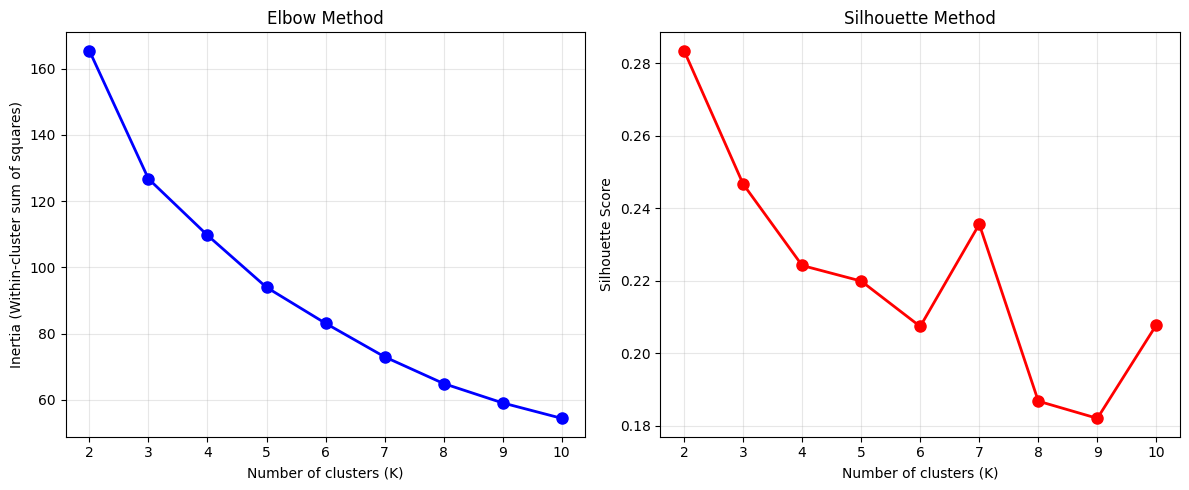


Best K according to silhouette method: 2
Best silhouette score: 0.284
For elbow method, look for the point where the curve starts to flatten (the 'elbow')


In [29]:
# 7.5 Find optimal K using elbow and silhouette methods
print("\n--- Finding optimal number of clusters ---")

# I'll test different values of K to see which works best
k_values = range(2, 11)  # Test from 2 to 10 clusters
inertias = []
silhouette_scores = []

for k in k_values:
    # Use k-means++ since it's more stable
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    km.fit(df_np)
    
    inertias.append(km.inertia_)
    sil_score = silhouette_score(df_np, km.labels_)
    silhouette_scores.append(sil_score)
    
    print(f"K={k}: Inertia={km.inertia_:.3f}, Silhouette={sil_score:.3f}")

# Plot both methods to choose optimal K
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Elbow method plot
ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters (K)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.grid(True, alpha=0.3)

# Silhouette method plot
ax2.plot(k_values, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_title('Silhouette Method')
ax2.set_xlabel('Number of clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best K according to silhouette score
best_k_idx = np.argmax(silhouette_scores)
optimal_k = k_values[best_k_idx]
print(f"\nBest K according to silhouette method: {optimal_k}")
print(f"Best silhouette score: {silhouette_scores[best_k_idx]:.3f}")
print("For elbow method, look for the point where the curve starts to flatten (the 'elbow')")

### 8. K-Means (continued)

1. For the optimal value of $K$, list the names and star ratings of the hotels in each cluster.

1. Visualize the clustering in 2D and analyze the clustering result. 

1. Check whether it is possible to automatically retrieve the classification of hotels based on their stars. To do this, apply the K-means method with $K=6$, since there are $6$ star categories (0 to 5), and examine the relationship between the star rating of the hotels and their clusters. To quantify the matching between the clustering result (given by the `labels_` attribute) and the star classification (given by the ETOILE column), you can use the Adjusted Rand Index.

In [30]:
# 8.1 Apply K-means with optimal K and list hotels by cluster
print("=== Using optimal K for final clustering ===")

# Use the best K we found in point 7.5
final_kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
final_kmeans.fit(df_np)

final_silhouette = silhouette_score(df_np, final_kmeans.labels_)
print(f"Final K-means clustering with K={optimal_k}")
print(f"Silhouette score: {final_silhouette:.3f}")

# 8.1 List hotels in each cluster
print(f"\n=== Hotels by cluster ===")
for cluster_num in range(optimal_k):
    # Find which hotels belong to this cluster
    cluster_mask = final_kmeans.labels_ == cluster_num
    hotels_in_cluster = hotel_names[cluster_mask]
    stars_in_cluster = hotel_stars[cluster_mask]
    
    print(f"\nCluster {cluster_num + 1} ({len(hotels_in_cluster)} hotels):")
    for hotel, stars in zip(hotels_in_cluster, stars_in_cluster):
        print(f"  - {hotel} ({stars}★)")

print(f"\nAll {len(hotel_names)} hotels distributed across {optimal_k} clusters")

=== Using optimal K for final clustering ===
Final K-means clustering with K=2
Silhouette score: 0.284

=== Hotels by cluster ===

Cluster 1 (10 hotels):
  - Appolpon (1★)
  - Christina (2★)
  - Economy (1★)
  - EdenBeach (1★)
  - Agdal (4★)
  - Almohades (4★)
  - Chems (4★)
  - SudBahia (4★)
  - Mimosa (2★)
  - Hippocampe (1★)

Cluster 2 (29 hotels):
  - Caravel (4★)
  - HanikianBeach (3★)
  - MarinaBeach (3★)
  - Xenia (3★)
  - Atlas (4★)
  - AtlasArnadi (4★)
  - Dunesdor (3★)
  - LaResidence (0★)
  - MDiq (0★)
  - Omayades (4★)
  - Sahara (5★)
  - TourHassan (5★)
  - AlfaMar (4★)
  - AppDoMar (4★)
  - DeLagos (4★)
  - Madeira (5★)
  - Reids (5★)
  - AbouSofiane (3★)
  - Asdrubal (4★)
  - Colombes (3★)
  - Darnaour (2★)
  - Djerba (3★)
  - Omarit (3★)
  - Orangers (3★)
  - Penelope (0★)
  - Ulysse (4★)
  - DauphinOr (3★)
  - KuriatPalace (4★)
  - Sultan (0★)

All 39 hotels distributed across 2 clusters



=== 2D Visualization of K-means results ===


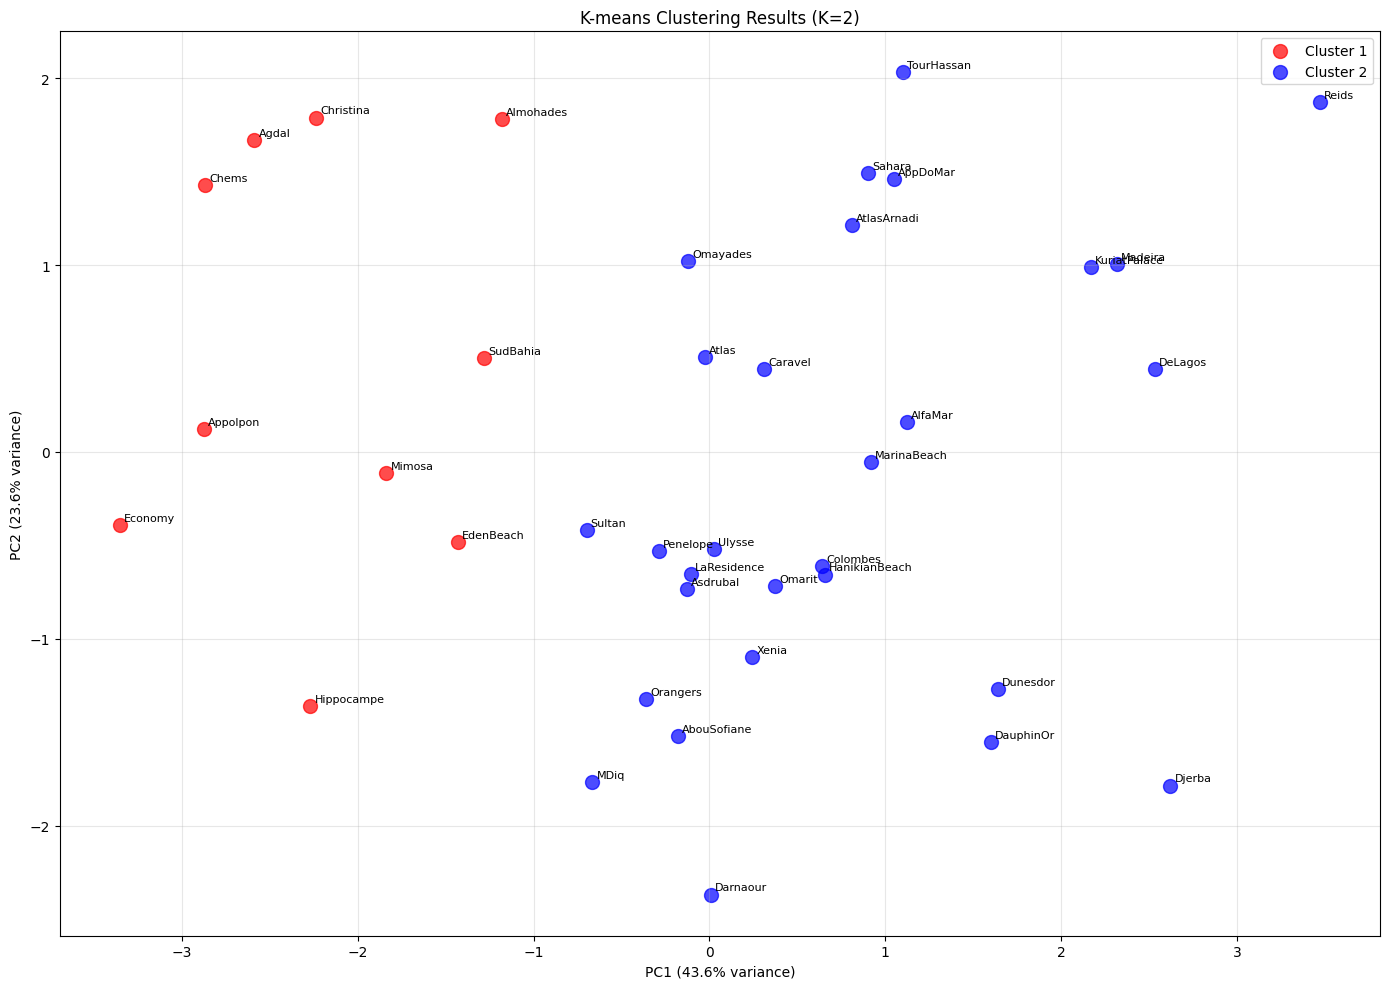

The plot shows how hotels are grouped based on their characteristics.
Hotels close together have similar features (comfort, price, cuisine, etc.)


In [31]:
# 8.2 Visualize clustering in 2D
print("\n=== 2D Visualization of K-means results ===")

plt.figure(figsize=(14, 10))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Plot each cluster with different color
for cluster_num in range(optimal_k):
    cluster_mask = final_kmeans.labels_ == cluster_num
    
    plt.scatter(pca_coords[cluster_mask, 0], 
               pca_coords[cluster_mask, 1], 
               c=colors[cluster_num], 
               label=f'Cluster {cluster_num + 1}', 
               s=100, alpha=0.7)
    
    # Add hotel names as labels on the plot
    for i in np.where(cluster_mask)[0]:
        plt.annotate(hotel_names.iloc[i], 
                    (pca_coords[i, 0], pca_coords[i, 1]),
                    xytext=(3, 3), textcoords='offset points',
                    fontsize=8)

plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
plt.title(f'K-means Clustering Results (K={optimal_k})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("The plot shows how hotels are grouped based on their characteristics.")
print("Hotels close together have similar features (comfort, price, cuisine, etc.)")

In [32]:
# 8.3 Compare with star classification using K=6
print("\n=== Comparison with hotel star classification ===")
print("Testing K=6 to match the 6 star categories (0, 1, 2, 3, 4, 5 stars)")

# Apply K-means with K=6 to match star categories
kmeans_6 = KMeans(n_clusters=6, init='k-means++', n_init=10, random_state=42)
kmeans_6.fit(df_np)

silhouette_6 = silhouette_score(df_np, kmeans_6.labels_)
print(f"K-means with K=6 clusters:")
print(f"Silhouette score: {silhouette_6:.3f}")

# Calculate ARI to measure how well clustering matches star classification
ari_with_stars = adjusted_rand_score(hotel_stars, kmeans_6.labels_)
print(f"ARI between clustering and star ratings: {ari_with_stars:.3f}")

# Interpret the result
if ari_with_stars > 0.5:
    interpretation = "Strong correspondence - clustering matches star ratings well!"
elif ari_with_stars > 0.3:
    interpretation = "Moderate correspondence - some alignment with star ratings."
else:
    interpretation = "Weak correspondence - clustering doesn't align well with star ratings."

print(f"Interpretation: {interpretation}")

# Show detailed cluster-star relationship
print(f"\n=== Detailed cluster-star relationship ===")
cluster_star_df = pd.DataFrame({
    'Hotel': hotel_names.values,
    'Stars': hotel_stars.values,
    'Cluster': kmeans_6.labels_ + 1  # +1 to start clusters from 1
})

print("Star distribution in each cluster:")
for cluster in range(1, 7):
    cluster_data = cluster_star_df[cluster_star_df['Cluster'] == cluster]
    star_counts = cluster_data['Stars'].value_counts().sort_index()
    print(f"Cluster {cluster}: {dict(star_counts)}")

print(f"\n=== Final conclusion ===")
print(f"ARI = {ari_with_stars:.3f} shows that automatic clustering based on hotel features")
if ari_with_stars > 0.3:
    print("has some correspondence with the official star classification.")
    print("This suggests that star ratings partially reflect measurable hotel characteristics.")
else:
    print("doesn't align well with the official star classification.")
    print("This suggests that star ratings don't perfectly match the measured hotel features.")
    print("Star ratings might include subjective factors not captured in our data.")


=== Comparison with hotel star classification ===
Testing K=6 to match the 6 star categories (0, 1, 2, 3, 4, 5 stars)
K-means with K=6 clusters:
Silhouette score: 0.207
ARI between clustering and star ratings: 0.170
Interpretation: Weak correspondence - clustering doesn't align well with star ratings.

=== Detailed cluster-star relationship ===
Star distribution in each cluster:
Cluster 1: {1: np.int64(3)}
Cluster 2: {0: np.int64(2), 2: np.int64(1), 3: np.int64(5)}
Cluster 3: {0: np.int64(2), 3: np.int64(5), 4: np.int64(5)}
Cluster 4: {1: np.int64(1), 2: np.int64(2), 4: np.int64(3)}
Cluster 5: {4: np.int64(3), 5: np.int64(1)}
Cluster 6: {4: np.int64(3), 5: np.int64(3)}

=== Final conclusion ===
ARI = 0.170 shows that automatic clustering based on hotel features
doesn't align well with the official star classification.
This suggests that star ratings don't perfectly match the measured hotel features.
Star ratings might include subjective factors not captured in our data.
